# Exercise

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works and then use it on a bigger dataset of 5000 face images.

## Example Dataset

I will first start with a 2D dataset which has one direction of large variation and one of smaller variation. I will visualize what happens when we use PCA to reduce the data from 2D to 1D.

### Principal Component Analysis

#### Importing libraries and data

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# Will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [2]:
# Load the dataset into the variable x 
data = loadmat('Data/ex7data1.mat')
x = data['X']

#### Visualizing the data

First I will start by visualizing the data to have a better idea of what I am working with.

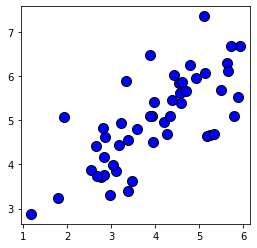

In [3]:
plt.plot(x[:, 0], x[:, 1], 'bo', ms=10, mec='k')
plt.gca().set_aspect('equal') # Axes use the same scale

#### Mean normalization

Before implementing PCA, it is important to scale the features to make sure that each feature has similar weight. For this I will write the function `meanNormalization`.

In [4]:
def meanNormalization(x):
    
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0, ddof=1)
    
    x_norm = (x - mean) / std

    return x_norm, mean, std

#### Implementing PCA

Now I will implement PCA which consists of two steps: 

1. Compute the covariance matrix of the data.
2. Use Singular Value Decomposition (SVD) to compute the eigenvectors $U_1$, $U_2$, $\dots$, $U_n$. These will correspond to the principal components of variation in the data.

The covariance matrix of the data is given by:

$$ \Sigma = \frac{1}{m} x^T x$$

where $x$ is the data matrix with examples in rows, and $m$ is the number of examples.

In [5]:
def PCA(x):
    # Number of training examples
    m = x.shape[0]

    Sigma = (1 / m) * x.T.dot(x)
    U, S, V = np.linalg.svd(Sigma)
    
    return U, S, V

Eigenvectors:
[[-0.707107 -0.707107]
 [-0.707107  0.707107]]


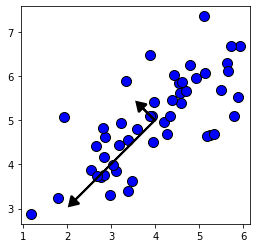

In [6]:
# Scale features
x_norm, mean, std = meanNormalization(x)

#  Run PCA
U, S, V = PCA(x_norm)

# Plot eigenvectors over the data - Draws the eigenvectors centered at mean of the data
# These vectors show the directions of maximum variations in the dataset
fig, ax = plt.subplots()
ax.plot(x[:, 0], x[:, 1], 'bo', ms=10, mec='k')

for i in range(2):
    ax.arrow(mean[0], mean[1], 1.5 * S[i] * U[0, i], 1.5 * S[i] * U[1, i],
             head_width=0.25, head_length=0.2, fc='k', lw=2, zorder=1000)

ax.set_aspect('equal') # Axes use the same scale

print('Eigenvectors:')
print(f'{np.round(U, 6)}')

### Dimensionality Reduction with PCA

After computing the eigenvectors $U$ (principal components), I can use them to reduce the feature dimension of the dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)}$ (in this case, projecting the data from 2D to 1D). 

**Note:** If I was using a learning algorithm such as linear regression, neural networks, etc... I could now use the projected data instead of the original data. By using the projected data, I can train my model faster as there are less dimensions in the input.

#### Projecting the data onto the principal components

I will write the function `projectData` to project each example in `x` onto the top `K` components in `U`, in which `K` is the number of dimensions that I want to reduce to.

In [7]:
def projectData(x, U, K):
    U_reduce = U[:, :K]
    z = x.dot(U_reduce)

    return z

#### Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, I can approximately recover the data by projecting it back onto the original high dimensional space. For this, I will write the function `recoverData`.

In [8]:
def recoverData(z, U, K):
    U_reduce = U[:, :K]
    x_recovered = z.dot(U_reduce.T)

    return x_recovered

In the next cell I will run these 2 functions and plot the original data and the recovered data in the same figure to compare the two.

This will show me what the data looks like when using only the corresponding eigenvectors to reconstruct it.

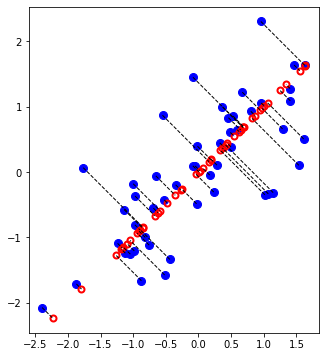

In [9]:
# Project the data onto 1 dimension (K = 1)
K = 1
z = projectData(x_norm, U, K)

# Reconstruct data from projection
x_recovered  = recoverData(z, U, K)

# Plot the normalized dataset and the reconstructed dataset
plt.figure(figsize=(6,6))
plt.plot(x_norm[:, 0], x_norm[:, 1], 'bo', ms=8, mec='b')
plt.plot(x_recovered[:, 0], x_recovered[:, 1], 'ro', mec='r', mew=2, mfc='none')
plt.gca().set_aspect('equal')

# Draw lines connecting the projected points to the original points
for x_norm, x_rec in zip(x_norm, x_recovered):
    plt.plot([x_norm[0], x_rec[0]], [x_norm[1], x_rec[1]], '--k', lw=1)

The projection effectively only retains the information in the direction given by $U_1$. The dotted lines show the distance from the data points in the original space to the projected space, representing the error measure due to PCA projection.

### Face Images Dataset

After gaining intuition of how PCA works with the example dataset, it is time to run PCA on the face images dataset to see how it can be used in practice for dimension reduction. The dataset `ex7faces.mat` contains a dataset `x` of face images, each image $32 \times 32$ pixels in grayscale. Each row of `x` corresponds to one face image (a row vector of length 1024 = 32 x 32). This dataset is based on a [cropped version](http://conradsanderson.id.au/lfwcrop/) of the [labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/) dataset.

#### Load and visualize data

I will start by visualizing a subset of the dataset. I will use the function `displayData` that picks 100 randomly selected rows from `x` and maps each row to a 32 pixel by 32 pixel grayscale image and displays the images together.

In [10]:
#  Load dataset
data = loadmat('Data/ex7faces.mat')
x = data['X']

m = x.shape[0] # Number of training examples

indices_to_display = np.random.choice(m, 100, replace=False)
selection = x[indices_to_display, :] # contains 100 random rows from x

def displayData(x, figsize=(10, 10)):
    # Compute rows, cols
    if x.ndim == 2:
        m, n = x.shape
    elif x.ndim == 1: #This allows vectors to be displayed as well
        n = x.size
        m = 1
        x = x[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input x should be 1 or 2 dimensional')
        
    width, height = 32, 32 # width and height of each digit image (32x32 pixel images)
    display_rows = int(np.floor(np.sqrt(m))) # Plot height
    display_cols = int(np.ceil(m / display_rows)) # Plot width
    
    # ax_array will store all axes objects (each row will have display_cols objects with a total of display_rows)
    # axes objects are where we will display each image
    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025) # Creates gaps between the images
    
    #If x is a vector then create list of the vector otherwise flatten the array
    ax_array = [ax_array] if m == 1 else ax_array.ravel()
    
    for i, ax in enumerate(ax_array):
        #In each axis object we will display the image of a digit
        ax.imshow(x[i].reshape(width, height, order='F'), cmap='gray')
        # order='F' turns the images 90 degrees counter-clockwise, cmap is the color palette for the img and
        # Extent defines the left, right, bottom and top limits
        ax.axis('off') # Turns off the axes for the images

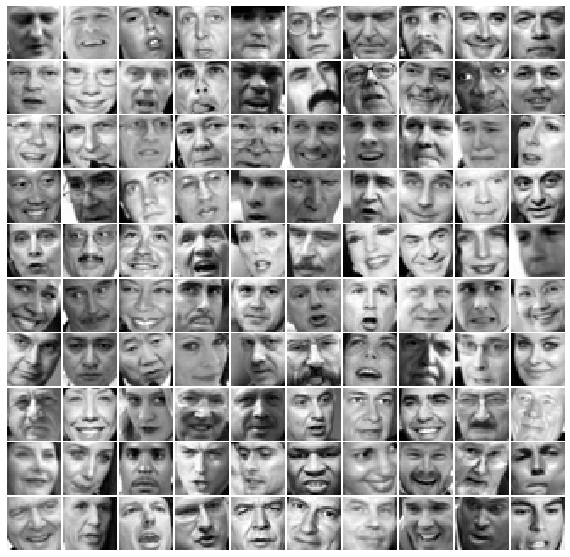

In [11]:
displayData(selection)

#### Running PCA

To run PCA on the dataset, I will first scale the features by mean normalizing each feature from the data matrix `x`.  After running PCA, I will obtain the principal components of the dataset. Each principal component in `U` (each column) is a vector of length $n$ ($n = 1024$). I can visualize these principal components by reshaping each of them into a $32 \times 32$ matrix that corresponds to the pixels in the original dataset. 

I will visualize the first 36 principal components that describe the largest variations. If I want more or less details, I increase or decrease, respectively, the number of dimensions that I want to reduce to.

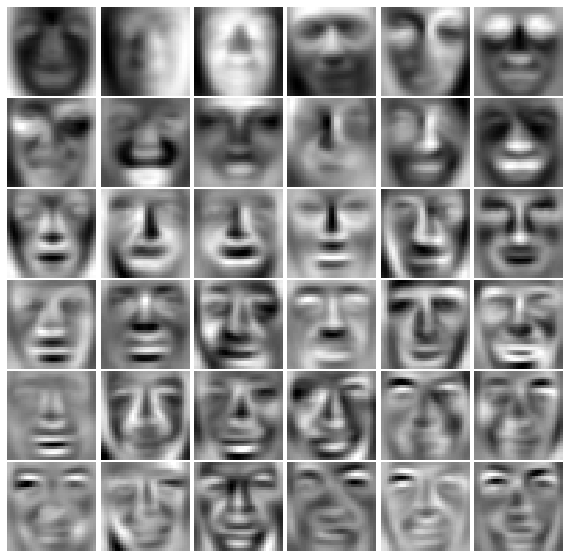

In [12]:
# Scale features
x_norm, mean, std = meanNormalization(x)

#  Run PCA
U, S, V = PCA(x_norm)

# Visualize the top 36 eigenvectors found
displayData(U[:, :36].T)

#### Running dimensionality reduction

Now that I have computed the principal components for the dataset, I can use them to reduce the dimension of the dataset. This allows me to use my learning algorithm with a smaller input size (I will choose 100 dimensions) instead of the original 1024 dimensions. This can help speed up the learning algorithm.

I will project the dataset onto the first 100 principal components. Concretely, each face image is now described by a vector $z^{(i)} \in \mathbb{R}^{100}$. To understand what is lost in the dimension reduction, I will recover the data using the projected dataset and plot both the original dataset and the projected dataset.

Text(0.5, 0.98, 'Recovered faces')

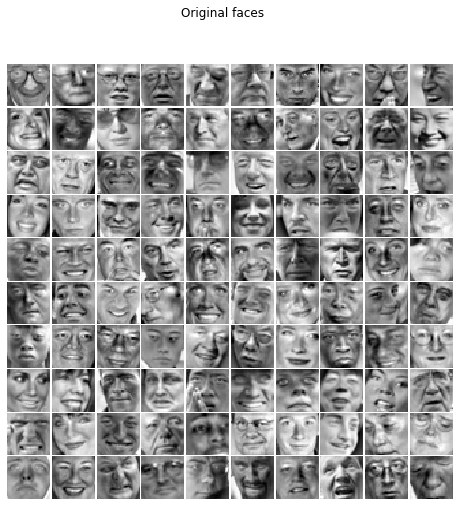

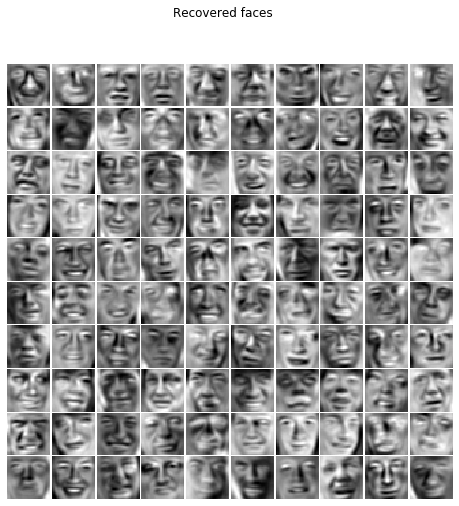

In [13]:
# Project data
K = 100 # Number of dimensions desired = 100
z = projectData(x_norm, U, K)

# Recover data
x_recovered = recoverData(z, U, K)

# Display normalized data
displayData(x_norm[:100, :], figsize=(8,8))
plt.gcf().suptitle('Original faces')

# Display recovered data
displayData(x_recovered[:100, :], figsize=(8,8))
plt.gcf().suptitle('Recovered faces')

From the reconstruction, we can observe that the general structure and appearance of the faces are kept while the fine details are lost. This is a big reduction (more than 10x) in the dataset size that can help speed up the learning algorithm significantly.

#### Dimensionality reduction for visualization

In the previous exercise, I used the K-means algorithm in the 3-dimensional RGB space to compress an image. I reduced each pixel of the RGB image to be represented by 16 clusters (16 colors). I will use the same image, run K-means again and visualize the final cluster assignments in a 3D space. Each data point is colored according to the cluster it has been assigned to.

Text(0.5, 0.92, 'Pixel dataset plotted in 3D')

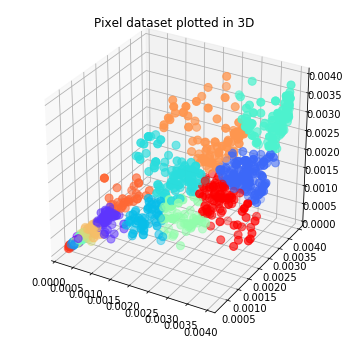

In [15]:
import import_ipynb
# Import K_means functions from previous exercise
from Kmeans_Clustering import K_means, moveCentroid, clusterAssignment, randomInitialization

# Load image
A = mpl.image.imread('Data/bird_small.png')
A /= 255
X = A.reshape(-1, 3)

# Settings for K-means
K = 16
max_iters = 10

# Run K-means
centroids, idx = K_means(X, K, randomInitialization, clusterAssignment, moveCentroid, max_iters, plot=False)

# Sample 1000 random indexes (since working with all the data is too expensive)
selection = np.random.choice(X.shape[0], size=1000)

# Plot data in 3D space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[selection, 0], X[selection, 1], X[selection, 2], cmap='rainbow', c=idx[selection], s=8**2)
ax.set_title('Pixel dataset plotted in 3D')

From the 3D plot above, we can see that visualizing datasets in 3 dimensions or greater can be difficult. Therefore, it is often desirable to only display the data in 2D even at the cost of losing some information. In practice, PCA is often used to reduce the dimensionality of data for visualization purposes. 

I will apply my implementation of PCA to the 3-dimensional data to reduce it to 2 dimensions and visualize the result in a 2D scatter plot. The PCA projection can be thought of as a rotation that selects the view that maximizes the spread of the data, which often corresponds to the “best” view.

Text(0.5, 1.0, 'Pixel dataset plotted in 2D, using PCA for dimensionality reduction')

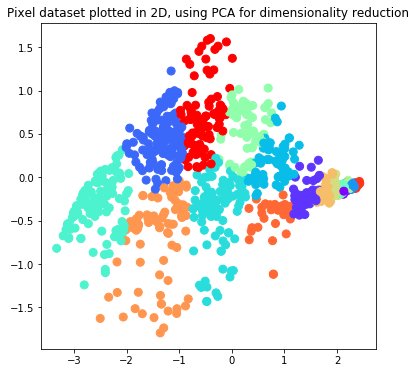

In [16]:
# Scale features
x_norm, mean, std = meanNormalization(X)

#  Run PCA
U, S, V = PCA(x_norm)

# Project data
K = 2 # 2 dimensions
z = projectData(x_norm, U, K)

# Plot data
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(z[selection, 0], z[selection, 1], cmap='rainbow', c=idx[selection], s=64)
ax.set_title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')

It is much easier to visualize data in 2D and we can clearly see the cluster distribution of the pixels by the 16 colors.